In [1]:
import numpy as np
import pandas as pd
from scipy.stats import kendalltau, spearmanr
import matplotlib.pyplot as plt

df = pd.read_csv('Brown_ratings_modified.csv')

In [2]:
# Verify scores
df['Calculated Score'] = df.apply(lambda row: int(row['Diviner Max Surface Temp']) +
                                               int(row['LOLA Albedo']) +
                                               int(row['LAMP Albedo']) +
                                               int(row['M3 NIR Ice Detection']) +
                                               int(row['Mini-RF CPR']) +
                                               int(row['LEND Neutron']) +
                                               int(row['LPNS Hydrogen']) + 2, axis=1)

correct_read = all(df['Calculated Score'] == df['Total Score'])
if not correct_read:
    print("The following PSRs have mismatched scores:")
    print(df[df['Calculated Score'] != df['Total Score']])
    print()

"""
NEED TO ACCOUNT FOR THE FACT THE NORTH POLE PSRS HAVE A SCORE 2 LOWER THAN THE SOUTH POLE ONES. THE THRESHOLD IS LOWER
South pole has 2 extra in the total score and 1 extra for the datasets which are being considered in the project
"""

# Calculate new scores
df['New Score'] = df.apply(lambda row: int(row['Diviner Max Surface Temp']) +
                                        int(row['LOLA Albedo']) +
                                        int(row['M3 NIR Ice Detection']) +
                                        int(row['Mini-RF CPR']), axis=1)

# Scores are converted to percentages to allow for North pole having two less points
# Total score for north pole is divided by 14, south pole is divided by 16. New score is divided by 7 for north pole and 8 for south pole
df['Total Score'] = df.apply(lambda row: row['Total Score'] / 16 if row['Pole'] == 'South' else row['Total Score'] / 14, axis=1)
df['New Score'] = df.apply(lambda row: row['New Score'] / 8 if row['Pole'] == 'South' else row['New Score'] / 7, axis=1)

# Sort DataFrame by score with secondary sort by PSR Name
sorted_by_total_score = df.sort_values(by=['Total Score', 'PSR Name'], ascending=[False, True])[['PSR Name', 'Total Score']].reset_index(drop=True)
sorted_by_new_score = df.sort_values(by=['New Score', 'PSR Name'], ascending=[False, True])[['PSR Name', 'New Score']].reset_index(drop=True)

# Convert to list
total_score_list = sorted_by_total_score['PSR Name'].tolist()
new_score_list = sorted_by_new_score['PSR Name'].tolist()

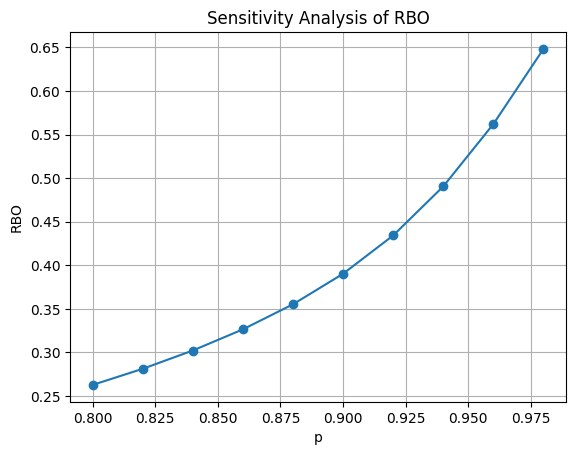

In [3]:
def rbo(list1, list2, p=0.98):
    """
    Calculates Rank-Biased Overlap (RBO) between two lists.
    p is a parameter that determines the weighting, with typical values between 0.8 and 0.98.
    """
    if list1 == list2:
        return 1.0
    
    s, d = list1, list2
    sl, dl = len(s), len(d)
    if sl > dl:
        s, d = d, s
        sl, dl = dl, sl

    ss, ds = set(), set()
    rbo_score = 0.0
    for i in range(sl):
        ss.add(s[i])
        ds.add(d[i])
        overlap = len(ss & ds) / (i + 1)
        rbo_score += overlap * (p ** (i + 1))

    for i in range(sl, dl):
        ds.add(d[i])
        overlap = len(ss & ds) / (i + 1)
        rbo_score += overlap * (p ** (i + 1))

    rbo_score = ((1 - p) * rbo_score) / (1 - p ** dl)
    
    return rbo_score

def sensitivity_analysis_rbo(list1, list2, p_values):
    rbo_values = {}
    for p in p_values:
        rbo_value = rbo(list1, list2, p)
        rbo_values[p] = rbo_value
    return rbo_values

p_values = np.linspace(0.8, 0.98, num=10)
rbo_values = sensitivity_analysis_rbo(total_score_list, new_score_list, p_values)

# plot RBO values for different p values
plt.plot(p_values, list(rbo_values.values()), marker='o')
plt.xlabel('p'); plt.ylabel('RBO'); plt.title('Sensitivity Analysis of RBO')
plt.grid()
plt.show()

In [4]:
tau, p_value = kendalltau(sorted_by_total_score['Total Score'], sorted_by_new_score['New Score'])
print(f"Kendall's Tau: {tau:.4f} (p-value: {p_value:.2e})")

spearman_corr, p_value = spearmanr(sorted_by_total_score['Total Score'], sorted_by_new_score['New Score'])
print(f"Spearman's Rank Correlation: {spearman_corr:.4f} (p-value: {p_value:.2e})")

Kendall's Tau: 0.8816 (p-value: 1.46e-18)
Spearman's Rank Correlation: 0.9426 (p-value: 1.06e-31)


Based on the sensitivity analysis for RBO, an input parameter `p` must be selected. A high value gives more weight to the top rows and a lower value gives equal weighting to all rows. The high correlation shown by Kendall's Tau and Spearman's Rank Correlation indicates that, across all rows, there is a high degree of similarity and therefore a slightly higher value of `p` will be selected to investigate the similarity of the lists at the higher end. 

In [5]:
p = 0.9
rbo_value = rbo(total_score_list, new_score_list, p=p)
print(f"Rank-Biased Overlap (RBO): {rbo_value:.4f}")

Rank-Biased Overlap (RBO): 0.3902


## Discussion of results

First, the values of each metric are evaluated separately. Kendall's Tau and Spearman's Rank Correlation both have a range of -1 to 1 where the former is perfect negative correlation, the latter is a perfect positive correlation and 0 is no correlation. RBO has a range of 0 to 1 where 0 indicates the two lists have no items in common at any rank and 1 indicates that the ranks are identical. 

- **Kendall's Tau and Spearman's Rank Correlation > 0.9:**<br>
Both metrics indicate a very strong positive correlation between the rankings of the two lists.

- **Rank-Biased Overlap (RBO) = 0.36:**<br>
Moderate overlap between the rankings, suggesting that while there is some agreement between the two lists, it is not as strong as suggested by Kendall's Tau and Spearman's Rank Correlation.

### Discrepancy Explanation

The discrepancy between the high values of Kendall's Tau and Spearman's Rank Correlation and the moderate RBO value could arise from the different nature of these metrics:

- Kendall's Tau and Spearman's Rank Correlation measure the strength and direction of the association between two rankings. They are sensitive to the overall order and consider every pair of rankings, thus providing a high correlation if the relative order of the majority of pairs is preserved.
  
- RBO measures the similarity between the top ranks of the two lists, putting more weight on the top items. If the top rankings are not very similar but the overall order of the lists is similar, Kendall's Tau and Spearman's Rank Correlation will still show a high correlation, while RBO will show a lower value.

In this case, the lower RBO value suggests that the similarity between the two lists is not as strong at the top ranks, even though the overall order of the items in the lists is quite similar. While Kendall's Tau and Spearman's Rank Correlation indicate very strong similarity, the RBO value provides additional nuance by highlighting that the agreement is not as strong among the top-ranked items.

### Interpretation

This is very important to note when comparing the results of this project with the results of Brown et al. and in understanding the importance of a higher number of datasets. For PSRs with low resource potential, fewer datasets are required to disqualify them and relegate them to a lower position on a rankings table, however, for PSRs with a higher potential to contain volatile materials, a larger number of datasets are needed to *analytically* distinguish between those top few. This makes the case of deep learning even more interesting. With the PSRs at the top of the list being the most important, dictating landing sites for missions such as Artemis and VIPER, an investigation into whether machine learning can better separate PSRs at the top of the list without the need for additional datasets becomes more important. 

Despite this finding, it is also important to note the potential for discrepancy in the final results of this project. Were the ML model able to perfectly reproduce the findings in Brown et al., the list that would be generated would be different to the findings of the paper, which considered a higher number of datasets. It is hoped that the use of ML can bridge the gap caused by the reduction in the number of datasets and produce a list closer to the one presented by Brown et al. 